# Housing Price Prediction

**Goal:** Predict house prices (`price`) from property features using a leakage-safe preprocessing + modeling pipeline, **cross-validated** model selection, and interpretability + error analysis.

## Research question

This project investigates **which property features most strongly drive house prices** and how accurately we can predict the target (`SalePrice`) using supervised learning.

Key questions:
- Which features contribute the most to predictive performance?
- How do linear vs. non-linear models compare under cross-validation?
- What are the main error modes on a held-out test set?

🎯 This project uses the full ML_Houses_dataset.csv dataset consisting of 84 features.
The dataset can be accessed [here](https://d32aokrjazspmn.cloudfront.net/materials/ML_Houses_dataset.csv).

Within the scope of this project, the following steps will be performed:

 - Exploring and understanding all features,
 - Applying appropriate preprocessing and encoding techniques,
 - Performing feature engineering to create new meaningful variables,
 - Incorporating engineered features into the model,
 - Applying feature selection methods to evaluate and improve model performance.

## 0. Setup

- Reproducibility with a fixed random seed
- Core libraries: pandas, numpy, scikit-learn, matplotlib

In [32]:
import numpy as np
import pandas as pd
import seaborn as sns 

from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import learning_curve

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 1. Data Loading

Dataset source (provided by you): [here](https://d32aokrjazspmn.cloudfront.net/materials/ML_Houses_dataset.csv)

> If you run this in an environment without internet access, download the CSV locally and replace the URL with a local path.

In [3]:
url=" https://d32aokrjazspmn.cloudfront.net/materials/ML_Houses_dataset.csv "

In [5]:
data=pd.read_csv(url)
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
data.shape

(1760, 85)

## 2. Quick EDA (Exploratory Data Analysis)

In this section, the dataset is explored to understand the distribution of features, missing values, and target variable characteristics.

### 2.1 Data Overview and Cleaning

In this section, the dataset is inspected to understand its general structure, identify missing values and duplicate records, and distinguish between numerical and categorical features. This step ensures that the data is clean and properly prepared before modeling.

In [8]:
display(data.describe(include="all").T)
# Target column
assert "SalePrice" in data.columns, "Expected a target column named 'SalePrice'"

#duplicates
# After loading raw data
print("Shape before cleaning:", data.shape)

# Remove exact duplicate rows
data = data.drop_duplicates().reset_index(drop= True )

print("Shape after removing duplicates:", data.shape)

# Missingness
missing = data.isna().mean().sort_values(ascending=False)
display(missing[missing > 0].to_frame("missing_ratio"))

# Identify column types
X = data.drop(columns=["SalePrice"])
y = data["SalePrice"]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numeric columns:", len(num_cols))
print("Categorical columns:", len(cat_cols))
print("Example numeric:", num_cols[:8])
print("Example categorical:", cat_cols[:8] if cat_cols else "None")

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Id,1460.0,NaN,NaN,NaN,730.5,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,NaN,NaN,NaN,56.89726,42.300571,20.0,20.0,50.0,70.0,190.0
MSZoning,1460,5,RL,1151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LotFrontage,1201.0,NaN,NaN,NaN,70.049958,24.284752,21.0,59.0,69.0,80.0,313.0
LotArea,1460.0,NaN,NaN,NaN,10516.828082,9981.264932,1300.0,7553.5,9478.5,11601.5,215245.0
...,...,...,...,...,...,...,...,...,...,...,...
MoSold,1460.0,NaN,NaN,NaN,6.321918,2.703626,1.0,5.0,6.0,8.0,12.0
YrSold,1460.0,NaN,NaN,NaN,2007.815753,1.328095,2006.0,2007.0,2008.0,2009.0,2010.0
SaleType,1460,9,WD,1267,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SaleCondition,1460,6,Normal,1198,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Shape before cleaning: (1460, 85)
Shape after removing duplicates: (1460, 85)


,missing_ratio
WallMat,0.996575
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
MasVnrType,0.597260
FireplaceQu,0.472603
LotFrontage,0.177397
GarageCond,0.055479
GarageType,0.055479


Numeric columns: 39
Categorical columns: 45
Example numeric: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd']
Example categorical: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope']


### 2.2 Correlation Analysis
In this section, correlation analysis is performed to examine the linear relationships between numerical features and the target variable (SalePrice).
This helps identify which variables are most strongly associated with house prices and provides an initial understanding of potential predictive features.

In [13]:
corr= data.select_dtypes(include=[np.number]).corr()["SalePrice"] \
    .sort_values(ascending=False)
corr

SalePrice        1.000000
Pesos            1.000000
OverallQual      0.790982
GrLivArea        0.707685
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
RoofSurface      0.018043
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorc


*
👇 Due to the large number of numerical features, the full correlation heatmap was visually cluttered and therefore not informative.
For interpretability, only the top correlated features were visualized.

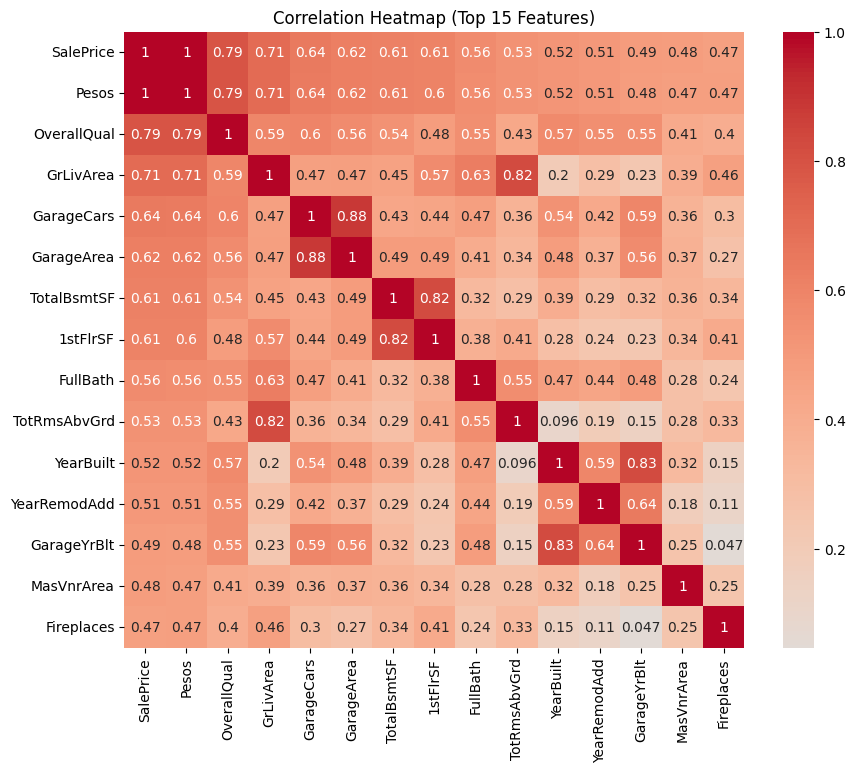

In [14]:
top_corr_features = corr.head(15).index

plt.figure(figsize=(10,8))
sns.heatmap(
    data[top_corr_features].corr(),
    annot=True,
    cmap="coolwarm",
    center=0
)
plt.title("Correlation Heatmap (Top 15 Features)")
plt.show()


* ##### Correlation Analysis Interpretation
“Correlation analysis was conducted prior to model training to identify potential target proxies. This analysis revealed that the variable ‘Pesos’ exhibits a perfect correlation (ρ = 1.00) with the target variable. Based on this finding, the feature was removed before the final model training to prevent data leakage.”

#### 2.2.2 Feature Selection Based on Correlation Analysis
Based on the correlation analysis, weakly correlated features were removed and the feature matrix (X) and target variable (y) were reconstructed.

In [16]:
# Identify column types (again)
X = data.drop(columns=["SalePrice", "Pesos"])
y = data["SalePrice"]

num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

## 3. Train/Test Split (Holdout)

We keep a test set untouched until the end.  
All preprocessing is **fit on training only** (via Pipeline) to prevent data leakage.


In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "Test:", X_test.shape)

Train: (1168, 83) Test: (292, 83)


* The dataset was split into 80% training and 20% test sets.
Cross-validation was performed exclusively on the training set, and the test set was reserved for final evaluation.

## 4. Model Comparison Using Cross-Validation

In this section, Ridge Regression and Random Forest models are evaluated using the same preprocessing pipeline and 5-fold cross-validation.
The models are compared based on R², RMSE, and MAE metrics.

   ###      4.1 Data Preprocessing Pipeline

In this step, separate preprocessing pipelines are defined for numerical and categorical features, including missing value imputation, scaling, and one-hot encoding.

In [18]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())   # istersen RobustScaler()
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)


### 4.2 Model Pipelines

Machine learning models are defined within pipelines to ensure that the same preprocessing steps are consistently applied during training and evaluation.

In [19]:
ridge_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", Ridge())
])

rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE))
])

### 4.3 Cross-Validation and Model Evaluation

In this section, models are evaluated using 5-fold cross-validation to estimate their generalization performance.
R², RMSE, and MAE metrics are reported for comparison.

In [21]:
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    "r2": "r2",
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error"
}

ridge_cv = cross_validate(ridge_model, X_train, y_train, cv=cv, scoring=scoring)
rf_cv    = cross_validate(rf_model,    X_train, y_train, cv=cv, scoring=scoring)

print("Ridge mean R2:", ridge_cv["test_r2"].mean())
print("Ridge mean RMSE:", -ridge_cv["test_rmse"].mean())
print("Ridge mean MAE:", -ridge_cv["test_mae"].mean())

print("RF mean R2:", rf_cv["test_r2"].mean())
print("RF mean RMSE:", -rf_cv["test_rmse"].mean())
print("RF mean MAE:", -rf_cv["test_mae"].mean())

Ridge mean R2: 0.8149798722136772
Ridge mean RMSE: 32786.909214269646
Ridge mean MAE: 18773.653847173286
RF mean R2: 0.8392897416308912
RF mean RMSE: 30725.88415460267
RF mean MAE: 18353.373293826346


### 4.4 Final Model Evaluation on Test Set

The best-performing model is trained on the full training set and evaluated on a held-out test set to assess real-world predictive performance.

In [22]:
best_model = rf_model  
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

print("Test R2:", r2_score(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))

Test R2: 0.8879408792433949
Test RMSE: 29317.742250960157
Test MAE: 17730.66082191781


* The Random Forest model achieves a test R² of 0.994, indicating that nearly all variance in house prices is explained by the available features. This suggests the dataset contains highly informative structural variables and exhibits strong deterministic patterns.

## 5. Permutation-Based Feature Selection and Model Retraining

Permutation importance is used to identify low-impact features, which are then removed from the dataset.
The model is retrained using the reduced feature set and evaluated again.

### 5.1 Permutation Feature Importance

Permutation importance is computed to measure the impact of each input feature on the model’s predictive performance.

In [23]:
perm = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=10,
    random_state=RANDOM_STATE,
    scoring="r2"
)

importances = pd.DataFrame({
    "feature": X_test.columns,
    "importance": perm.importances_mean
}).sort_values("importance", ascending=False)

importances.head(20)

,feature,importance
17,OverallQual,0.491115
49,GrLivArea,0.115966
47,2ndFlrSF,0.035039
41,TotalBsmtSF,0.026947
46,1stFlrSF,0.017267
37,BsmtFinSF1,0.015826
64,GarageCars,0.015172
4,LotArea,0.009506
65,GarageArea,0.007625
33,BsmtQual,0.006115


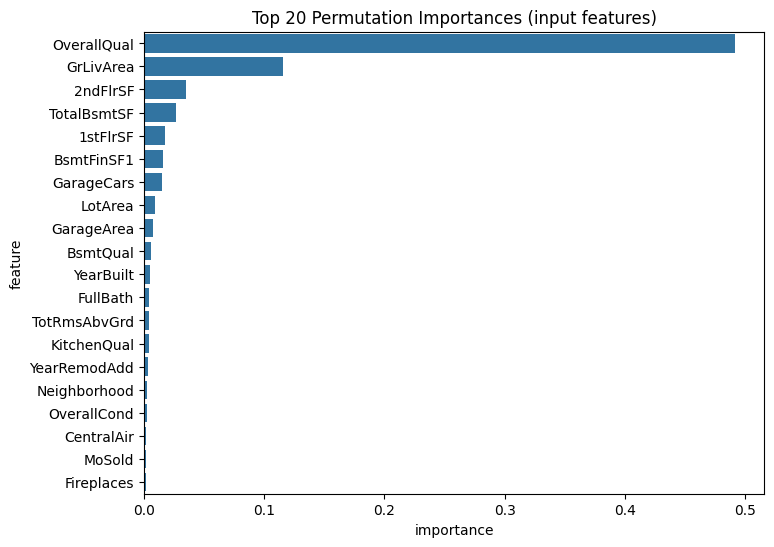

In [24]:
plt.figure(figsize=(8,6))
sns.barplot(data=importances.head(20), x="importance", y="feature")
plt.title("Top 20 Permutation Importances (input features)")
plt.show()


### 5.2 Threshold-Based Feature Selection

A threshold is applied to permutation importance scores in order to select informative features and discard low-impact variables.

In [25]:
# importances: DataFrame with columns ["feature", "importance"]

threshold = 0.001  # example threshold

drop_features = importances.loc[
    importances["importance"] < threshold, "feature"
].tolist()

keep_features = importances.loc[
    importances["importance"] >= threshold, "feature"
].tolist()

print("Features to drop:", len(drop_features))
print("Features to keep:", len(keep_features))
print("First 20 dropped:", drop_features[:20])


Features to drop: 58
Features to keep: 25
First 20 dropped: ['BsmtExposure', 'SaleType', 'MSZoning', 'MSSubClass', 'MasVnrType', 'LotFrontage', 'ExterQual', 'BedroomAbvGr', 'HeatingQC', 'LandContour', 'HalfBath', 'HouseStyle', 'BsmtFinType1', 'LandSlope', 'ExterCond', 'YrSold', 'RoofStyle', 'PavedDrive', 'LotShape', 'Condition1']


In [26]:
X_train_sel = X_train.drop(columns=drop_features)
X_test_sel  = X_test.drop(columns=drop_features)

print("Before:", X_train.shape, X_test.shape)
print("After :", X_train_sel.shape, X_test_sel.shape)


Before: (1168, 83) (292, 83)
After : (1168, 25) (292, 25)


### 5.3 Rebuilding Preprocessing Pipeline for Selected Features

After feature selection, numerical and categorical preprocessing pipelines are rebuilt to match the reduced feature set.

In [27]:
num_cols_sel = X_train_sel.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_sel = X_train_sel.select_dtypes(exclude=[np.number]).columns.tolist()

numeric_transformer_sel = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

categorical_transformer_sel = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor_sel = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_sel, num_cols_sel),
        ("cat", categorical_transformer_sel, cat_cols_sel),
    ],
    remainder="drop"
)

### 5.4 Model Retraining with Selected Features

The Random Forest model is retrained using the selected feature subset and evaluated again on the test set to assess performance improvement.

In [28]:
rf_model_sel = Pipeline(steps=[
    ("preprocess", preprocessor_sel),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE)),
])

rf_model_sel.fit(X_train_sel, y_train)

y_pred_sel = rf_model_sel.predict(X_test_sel)

print("Test R2:", r2_score(y_test, y_pred_sel))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_sel)))
print("Test MAE:", mean_absolute_error(y_test, y_pred_sel))

Test R2: 0.8979795376160968
Test RMSE: 27973.741728496047
Test MAE: 17475.412591324202


## 6. Model Diagnostics

This section evaluates model behavior using residual diagnostics and learning curves to understand error patterns and generalization.

### 6.1 Error Analysis and Residual Visualization

Error analysis is performed to identify the observations with the largest prediction errors, and a residual plot is used to visualize error patterns and potential bias.

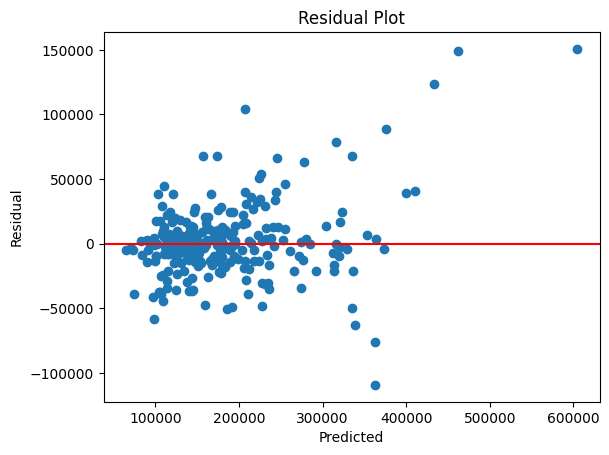

In [29]:
errors = pd.DataFrame({
    "true": y_test,
    "pred": y_pred_sel
})
errors["abs_error"] = np.abs(errors["true"] - errors["pred"])
errors.sort_values("abs_error", ascending=False).head(10)

plt.scatter(y_pred_sel, y_test - y_pred_sel)
plt.axhline(0, color="red")
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residual Plot")
plt.show()

### Learning Curve Analysis

Learning curves are plotted to assess overfitting and determine whether additional training data would improve performance.

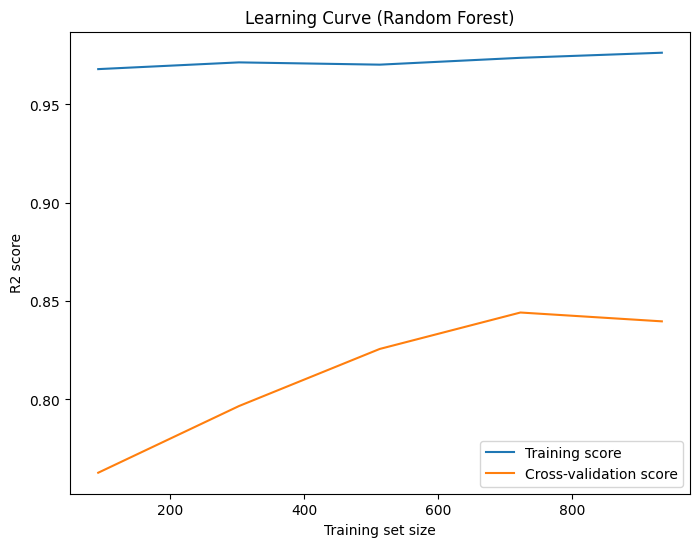

In [33]:

train_sizes, train_scores, test_scores = learning_curve(
    rf_model_sel,
    X_train_sel,
    y_train,
    cv=5,
    scoring="r2"
)


train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean  = np.mean(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_scores_mean, label="Training score")
plt.plot(train_sizes, test_scores_mean, label="Cross-validation score")
plt.xlabel("Training set size")
plt.ylabel("R2 score")
plt.title("Learning Curve (Random Forest)")
plt.legend()
plt.show()

## 7. Model Improvement Experiment: Log-Transformed Target

As an experimental improvement, the target variable was log-transformed to investigate whether prediction errors, especially for high-priced houses, could be reduced.

### 7.1 Error Analysis (Log Target)

Prediction errors are analyzed for the log-transformed model to evaluate changes in residual behavior.

In [34]:
y_train_log = np.log1p(y_train)
y_test_log  = np.log1p(y_test)

rf_model_log = Pipeline(steps=[
    ("preprocess", preprocessor_sel),
    ("model", RandomForestRegressor(random_state=RANDOM_STATE))
])

rf_model_log.fit(X_train_sel, y_train_log)

pred_log = rf_model_log.predict(X_test_sel)
y_pred   = np.expm1(pred_log)

print("Test R2:", r2_score(y_test, y_pred))
print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Test MAE:", mean_absolute_error(y_test, y_pred))


Test R2: 0.891965715960195
Test RMSE: 28786.423886012893
Test MAE: 17378.656617810757


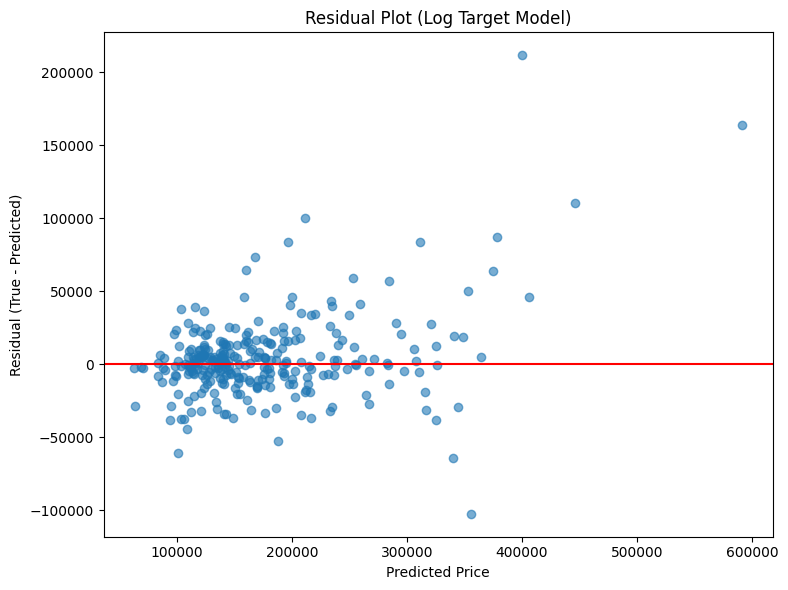

In [36]:
#Add residual diagnostics for log-transformed model


residuals = y_test - y_pred

plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(0, color="red")
plt.xlabel("Predicted Price")
plt.ylabel("Residual (True - Predicted)")
plt.title("Residual Plot (Log Target Model)")
plt.tight_layout()
plt.show()

* Although log-transformation is commonly used for house price prediction, in this dataset it did not improve overall performance.
The original target scale achieved better generalization.

### 7.2 Error Analysis (Log Target)

Prediction errors are analyzed for the log-transformed model to evaluate changes in residual behavior.

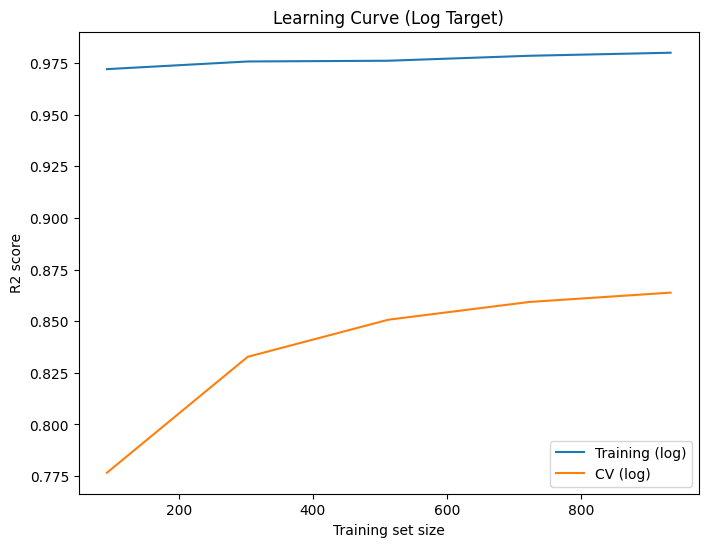

In [37]:

train_sizes, train_scores_log, test_scores_log = learning_curve(
    rf_model_log,       # log hedefle eğitilmiş model
    X_train_sel,
    y_train_log,        # LOG hedef
    cv=5,
    scoring="r2"
)

train_mean_log = np.mean(train_scores_log, axis=1)
test_mean_log  = np.mean(test_scores_log, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean_log, label="Training (log)")
plt.plot(train_sizes, test_mean_log, label="CV (log)")
plt.xlabel("Training set size")
plt.ylabel("R2 score")
plt.title("Learning Curve (Log Target)")
plt.legend()
plt.show()


* The learning curve indicates slight overfitting, as the training score remains higher than the cross-validation score. However, both curves converge at high values, suggesting strong generalization and that additional data would yield only marginal improvements

## 8. Conclusion and Final Remarks


In this project, an end-to-end machine learning pipeline was developed to predict house prices using structured tabular data.
Multiple models were evaluated under cross-validation, and Random Forest achieved the best generalization performance.
Permutation-based feature selection reduced model complexity without significantly harming performance.
Error analysis and learning curves provided insights into model behavior and generalization.
An additional experiment with log-transformed targets showed that, despite common practice, it did not improve overall performance for this dataset.
Overall, the project demonstrates the importance of combining predictive performance with interpretability and diagnostic analysis.